Great website for Textures :: https://pixela.ai/

# Random Forest in Depth - Chapter 02

## 0. Learning Objectives

* Diving further into Random forests
* For some datasets they work really well,  
* What do we do when they don't work
* What are the pros and cons of Random Forests
* What parameters can be tuned 
* Look at how we interpret the results of random forest

* FastAI library is highly **opinionated**
* Meaning, majority of the code is **wrapped** around existing libraries
* For example, for **structured** data there is already great code from the **scikit-learn** library
* This is wrapped under fast.ai library --> with most emphasis on have functions that reproduce **SOTA results**

## 1. Import Dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
currDir = os.getcwd()
os.chdir("../fastai/")
from structured import *       
from imports import *
os.chdir(currDir)
# ____________________________________________________________ #
from pandas_summary import DataFrameSummary
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
# ____________________________________________________________ #
import math

## 2. Data Pre-Processing

In [3]:
PATH2DATA = "../datasets/kaggle/bluebook_bulldozers/"
# !dir PATH2DATA  # view what is in the data directory

---

**STEP 1)**

* Read the data and say which columns are dates
* **Simlink** is used with the `ln -s` command
* You can also use `sys.append` but not recommended

In [4]:
df_raw = pd.read_csv(f'{PATH2DATA}Train.csv',
                     low_memory=False, parse_dates=["saledate"])


---

**STEP 2)**

* Now a better way of displaying the results 
* With the addittional property of setting the nos. of columns and rows to display

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

---

**STEP 3)**

* THen showing how only few of these last results can be displayed usign `tail()` method
* But this data has too many rows, so it will be much better to show it columns x row wise using `transpose()` method

In [6]:
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1.0,1.0,1.0,2.0,2.0
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


---

**STEP 4)**

* You need to check what type of loss function is used to train the dataset
* Can confirm it on Kaggle with the section on `evaluation`
* Then, accordinly change the data
* For example, Bluebook Bulldozers require `RMSLE` which means the dependant entries (in our case `Sale Price`) need to be `logged` as shown below
* This is $\sum (\ln{(actual)} * \ln{(preds)})^2$

In [7]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

---

**STEP 5)**

* Initialise the random forest algorithm
* Set it so that the dependant variable is Sale Price and all of the other columns except Sale Price are independant variables
* The exception of such nature is carried out using the `df_raw.drop` command

In [8]:
# rfalg = RandomForestRegressor(n_jobs=-1)
# rfalg.fit(df_raw.drop("SalePrice", axis=1), df_raw.SalePrice)

---

**STEP 6)**

* Make sure all the entries of tables are numbers
* In particular `extract` further features from the `Sale Date` column entry
* You can use `add_datepart` method in fast.ai library

In [9]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

f:\MAINPAPERWORK\CODE_PROJECTS\DATA_SCIENCE\FastAI\fastai\structured.py:115: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[targ_pre+n] = getattr(fld.dt,n.lower())
f:\MAINPAPERWORK\CODE_PROJECTS\DATA_SCIENCE\FastAI\fastai\structured.py:116: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9


0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

---

**STEP 7)**

* Make sure all the categorical (`string types`) entries of tables are converted into numbers
* You can use the `train_cat` or the `apply_cat` method in fast.ai library
* Allows us to map categorical data to 0, 1, ... n
* You can inspect this using the newly added `.cat.categories` method in fast.ai
* And use `.cat.codes` to see all the mappings of the categorical entries

In [10]:
train_cats(df_raw)
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [11]:
df_raw.UsageBand.cat.codes

0         1
1         1
2         0
3         0
4         2
         ..
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Length: 401125, dtype: int8

---

**STEP 8)**

* Manually set the categories to improve RFAlgol performance slightly
* This is done using the `.cat.set_categories` as endowed by the fast.ai libraries

In [12]:
df_raw.UsageBand.cat.set_categories(
    ["High", "Medium", "Low"], ordered=True, inplace=True)

c:\Users\ksfma\miniconda3\envs\airdmp\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


---

**STEP 9)**

* Remove any empty entries in the table
* You can first inspect those using `display_all` and then calculating percentages of empty or NaN entries within the table
* You can also use the `dtype` method to see that the type is now `Categorical` instead of a `string` which was its previous iteration
* Laslty, you use the `proc_df` method to convert all of the empty and non-numeric keys to numeric ones, but before that save the old df_raw `feather` format

In [13]:
df_raw.UsageBand.dtype

CategoricalDtype(categories=['High', 'Medium', 'Low'], ordered=True)

In [14]:
display_all(df_raw.isnull().sum().sort_index() / len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

* Saving method I could'nt get it to work !!

In [15]:
# # save using "feather" format
# if not os.path.exists('../raw_saves/'):
#     os.makedirs('../raw_saves', exist_ok=True)
# df_raw.to_feather('../raw_saves/')

* Use `proc_df` to convert all missing and non-numeric columns to **numeric** ones

In [16]:
df, y, _ = proc_df(df_raw, 'SalePrice')

## 3. Train on the Entire Dataset

**STEP 1)**

* Finally prepare the Random Forest Algorithm
* Fit and get the score for the performance on your data
* Takes about 5mins on CPU

In [17]:
# rfalg = RandomForestRegressor(n_jobs=-1)
# rfalg.fit(df, y)
# rfalg.score(df, y)

Max score getting is : `0.9881497324031044`

* The above is the `coefficient of determination`
* Also known as the $R^2$ value
* where ::
    * $y_i$ are the ground truth variables
    * $f_i$ are the model predictions (from RForest)
    * $\bar{y_i}$ are the Naive mean values

\begin{equation}
    R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = \frac{\sum_i (y_i - f_i)^2}{\sum_i (y_i - \bar{y})^2} = 1 - \frac{\text{how good is your model}}{\text{how good is the Naive model (just predict mean)}}
\end{equation}

* Some golden rule to look out for:
    * if `R=0` your model is as useless as the Naive model
    * if `R>0` your model is worse than the Naive model
    * if `R<0` your model is better than the Naive model

--- 

* But a sensible range to assess the performance is **anything less than 1**
* Why ? because you can tolerate 0 to 1, as long as you have an idea **how to improve** the model w.r.t Naive
* But ideally, less than 0 is good, you can also have $1 - \infty$ which again proves sensibility of the above anything less than 1 range

## 4. Setup Training and Validation Set

**STEP 2_**

* Have a validation set
* Why because just because you have a good performance measure, doesnt mean that you will not suffer from **OVERFITTING**
* How do you solve that ?
* Sure, you just make a validation set
* Before you make the validation set --> make sure that you come up with the dataset so that the score of your model on that dataset, should be good representation of how well your model will work in **real-life scenerio**
* I.e. on Kaggle, outside online venues such as Kaggle e.g. in industry and so on
* Often, in industry there is a bit of **disdain** against ML tech
* Often saying that ML model was good in training, but was rubbish in application time
* That's because their validation set was not **representative** of the real scenerio

---

* Another great hint is that the datasets with `temporal` information
* For example Bulldozers have `Sale Price` at a particular time
* So, in their dataset, they set the test set dates to have dates `in the future`
* Which makes both their validation and test better `representative` of the future

In [18]:
def split_vals(a, n):
    """
    a: number of samples (i.e. the entire dataset)
    n: number of training set to split
    """
    # a[:n] will retrieve the first (N - n_valid) rows for TRAINING set
    # a[n:] will retirve the last (N - n_valid) rows got VALIDATION set
    return a[:n].copy(), a[n:].copy()

* Now make total of 12000 validation splits

In [19]:
n_valid = 12000

# the number of training sets will be len(df) - n_valid
n_trn = len(df) - n_valid

# now split the entire dataset into training and validation
raw_train, raw_valid = split_vals(df_raw, n_trn)

# before were raw, now get the real ones based on pre-processed version
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [20]:
print("X_train shape: {}, y_train shape : {},  x_valid shape : {}".format(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape))

X_train shape: (389125, 66), y_train shape : (389125,),  x_valid shape : (12000, 66)


* `X_train` will be used to train the data
* `x_valid` will be used to see how good it is working on isYOUR PORTION of the set
* keep in mind the `test` set is UNKNOWN, yes it is a sub-set of the samples generated from the distribution that created the dataset, but the samples within it are unknown
* If you do know, then you run into the issue of `overfitting` your model on test set

## 5. Re_Train with Splitted Data

**STEP 1:**

* Previously, we trained on the entire data
* now re-train with training and validation set
* setup the loss function needed to evaluate our model (**RMSE**)
* make the prediction on certain bits of point in the data


In [21]:
def RMSE(x, y):
    return math.sqrt(((x - y) ** 2).mean())


def print_scores(m):
    result = [RMSE(m.predict(X_train), y_train), RMSE(m.predict(X_valid), y_valid),
              m.score(X_train, y_train), m.score(X_valid, y_valid)]

    # should also output "oob_score" if not then append to it
    if hasattr(m, 'oob_score'):
        result.append(m.oob_score)
    print(result)


In [22]:
# rfalg = RandomForestRegressor(n_jobs=-1)
# %time rfalg.fit(X_train, y_train)
# print_scores(rfalg)

CPU times: user 13min 42s, sys: 8.78 s, total: 13min 50s
Wall time: 5min 26s
[0.075577711024464, 0.23393271834047347, 0.9880622550698115, 0.9022695476674705]

**STEP 2:**

* Basically speeding using `random sampling` of the data
* Let's speed things up with using the `subset` argument in the `proc_df` function
* And then train the model on the new samples again and compare the time
* We dont want to store `X_val` because we dont want it to be overwritten, so that we make different models and compare their performance jointly
* But we change `X_train` so that it doesnt overlap with the dates
* If the above two do not happen then clearly we are cheating

In [23]:
df_train, y_train, _ = proc_df(df_raw, 'SalePrice', subset=30000)
X_train, _ = split_vals(df_train, 20000)
y_train, _ = split_vals(y_train, 20000)

# -------------------------------------------------------------- #

rfalg = RandomForestRegressor(n_jobs=-1)
%time rfalg.fit(X_train, y_train)
print_scores(rfalg)

Wall time: 4.33 s
[0.09257551020179472, 0.3402672926394599, 0.9813499038937448, 0.7932295917616331, False]


[Asus Times] CPU times: user 26.2 s, sys: 216 ms, total: 26.4 s
Wall time: 11.7 s
[0.09430785246087922, 0.35056357955351314, 0.9808376570177445, 0.7805267658193739]

* Shiiitt, the time changed from **13min** to **26.2**, dayum !! that's FINE

**STEP 3:**

* Setup the RForestRegressor
* And then find a single run
* In Sklearn, these are called estimators, so we set that to 1 for `n_estimators` to get ouput from one tree
* To stop the RForest algorithm to randomize the tree, we set `bootstrap` to False
* This will make a small `deterministic` tree
* Notice how score drops from 0.85 to 0.397
* However, it is better than 0 so it is better than Naive ?? not sure, i think this statement is wrong !
* It is not a good model, but it is model we can draw for sure

In [24]:
rfalg = RandomForestRegressor(n_estimators=1, 
    max_depth=3, bootstrap=False, n_jobs=-1)
rfalg.fit(X_train, y_train)
print_scores(rfalg)

[0.5229538689807635, 0.5822250640807733, 0.4048648430409887, 0.39461763076043566, False]


* A tree consists of `binary decisions`
* Otherwise known as `binary splits`
* The `samples` entry found in the third point in each node, shows how many samples/rows are there for that split
* The darker the colour of the node, the higher the value it has
* The average of `log of price` is stored as `value` field
* And if we build a model which uses the Naive method all the time, the `MSE` will store the loss
* The first step to create the first tree, is to use the create the first `binary decision`
* You can use `linear regression` to accomplish, but then again we are not assuming any `statistical assumption` 

---

* A simpler method is to `choose variables` for each node (binary point)
* And also choose what to split on
* Split in for example decide from the population such that they are splitted `heterogenously`
* Means the dividing sub-samples have different attributes from one another
* Both each of the samples within the subset have `homoegenuous` properties
* For each variable, see whether it is better

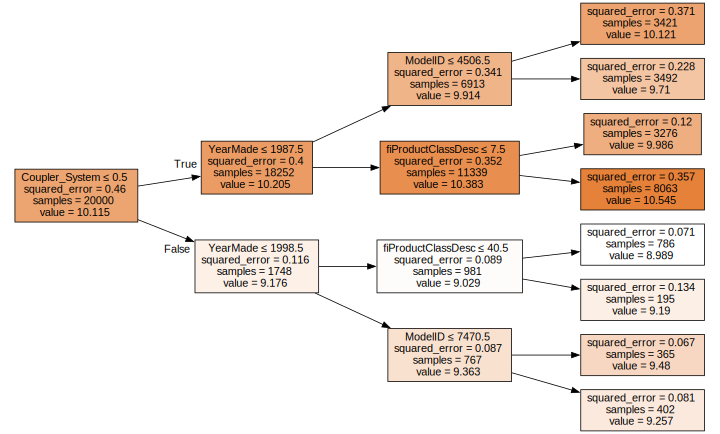

In [26]:
draw_tree(rfalg.estimators_[0], df_train, precision=3)

In [27]:
xxxxxx

NameError: name 'xxxxxx' is not defined